# Include Basic Tools

### Import Required Libraries

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import shap

### Helper Functions

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def wmape(y_true, y_pred):
    denom = np.sum(np.abs(y_true))
    return np.sum(np.abs(y_true - y_pred)) / denom if denom != 0 else np.nan

# Load Dataset 

In [3]:
DATA_DIR = "data/"
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), parse_dates=["Date"])
test  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"),  parse_dates=["Date"])
store = pd.read_csv(os.path.join(DATA_DIR, "store.csv"))

C:\Users\User\AppData\Local\Temp\ipykernel_26904\2442455010.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), parse_dates=["Date"])


In [4]:
print(train.shape, test.shape, store.shape)

(1017209, 9) (41088, 8) (1115, 10)


In [5]:
print("Train missing values:")
print(train.isna().sum())
print("\nTest missing values:")
print(test.isna().sum())
print("\nStore missing values:")
print(store.isna().sum())

Train missing values:
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Test missing values:
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store missing values:
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [6]:
# Some basic cleaning consistent with many Rossmann kernels
test['Open']  = test['Open'].fillna(1).astype(int)

# Merge store info into train/test
train = train.merge(store, how='left', on='Store')
test  = test.merge(store, how='left', on='Store')

# EDA

In [7]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,1017209.0,558.429727,1.0,280.0,558.0,838.0,1115.0,321.908651
DayOfWeek,1017209.0,3.998341,1.0,2.0,4.0,6.0,7.0,1.997391
Date,1017209,2014-04-11 01:30:42.846061824,2013-01-01 00:00:00,2013-08-17 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,NaN
Sales,1017209.0,5773.818972,0.0,3727.0,5744.0,7856.0,41551.0,3849.926175
Customers,1017209.0,633.145946,0.0,405.0,609.0,837.0,7388.0,464.411734
Open,1017209.0,0.830107,0.0,1.0,1.0,1.0,1.0,0.375539
Promo,1017209.0,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759
SchoolHoliday,1017209.0,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056
CompetitionDistance,1014567.0,5430.085652,20.0,710.0,2330.0,6890.0,75860.0,7715.3237
CompetitionOpenSinceMonth,693861.0,7.222866,1.0,4.0,8.0,10.0,12.0,3.211832


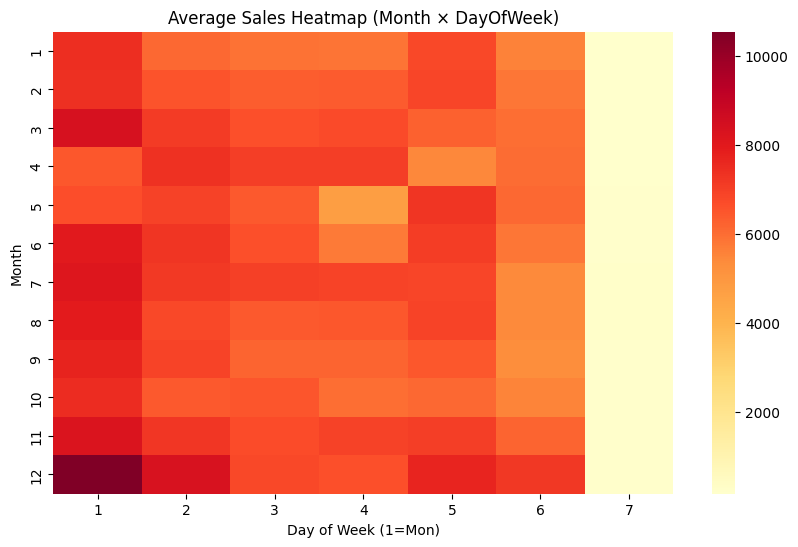

In [8]:
pivot = train.pivot_table(
    values='Sales',
    index=train['Date'].dt.month,
    columns='DayOfWeek',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='YlOrRd')
plt.title("Average Sales Heatmap (Month × DayOfWeek)")
plt.xlabel("Day of Week (1=Mon)")
plt.ylabel("Month")
plt.show()


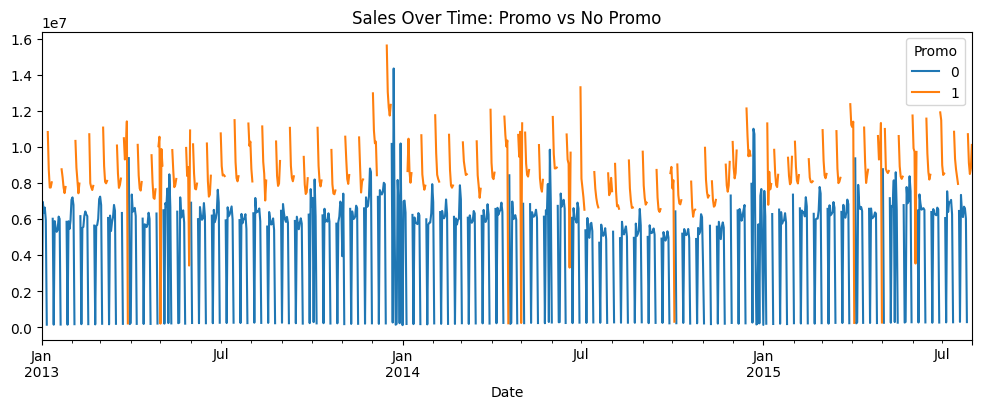

In [9]:
promo_time = train.groupby(['Date','Promo'])['Sales'].sum().unstack()

promo_time.plot(figsize=(12,4))
plt.title("Sales Over Time: Promo vs No Promo")
plt.show()

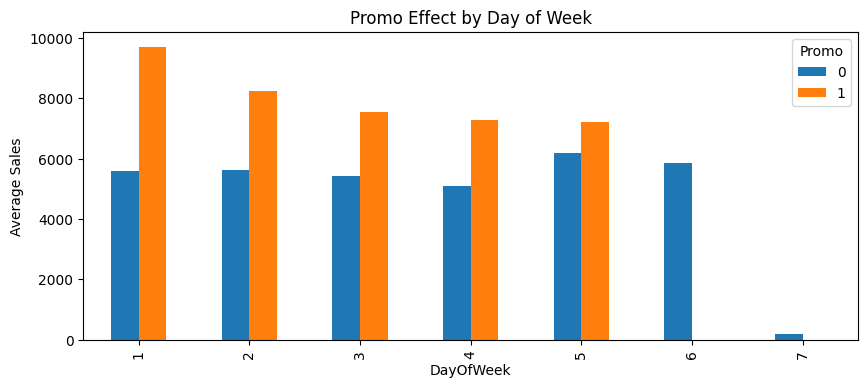

In [10]:
promo_dow = train.groupby(['DayOfWeek','Promo'])['Sales'].mean().unstack()

promo_dow.plot(kind='bar', figsize=(10,4))
plt.title("Promo Effect by Day of Week")
plt.ylabel("Average Sales")
plt.show()


# Preprocessing & Feature Engineeruing

### Basic date features

In [11]:
def add_date_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek + 1
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['IsWeekend'] = (df['DayOfWeek'].isin([6,7])).astype(int)
    return df

train = add_date_features(train)
test  = add_date_features(test)

###  Combine train + test to compute lags/rolling features

In [12]:
# mark datasets
train['dataset'] = 'train'
test['dataset'] = 'test'

# for lags/rolling, we need Sales available for train and missing for test
all_df = pd.concat([train, test], sort=False).sort_values(['Store', 'Date']).reset_index(drop=True)
print(all_df.shape)

(1058297, 25)


### Create lag features (lag days) and rolling statistics

In [ ]:
# ensure Sales numeric
all_df['Sales'] = all_df['Sales'].astype(float)

LAGS = [7, 14, 28]
ROLL_WINDOWS = [7, 30]

for lag in LAGS:
    all_df[f'lag_{lag}'] = all_df.groupby('Store')['Sales'].shift(lag)

# rolling means of previous days (shift first to exclude current day)
for w in ROLL_WINDOWS:
    all_df[f'rolling_mean_{w}'] = all_df.groupby('Store')['Sales'].shift(1).rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)

all_df['rolling_std_30'] = all_df.groupby('Store')['Sales'].shift(1).rolling(window=30, min_periods=1).std().reset_index(level=0, drop=True)

### Promo/competition/store categorical handling & simple filling

In [14]:
all_df['StateHoliday'] = all_df['StateHoliday'].astype(str)
all_df['Promo'] = all_df['Promo'].fillna(0).astype(int)
all_df['CompetitionDistance'] = all_df['CompetitionDistance'].fillna(1e5)  # large distance when missing
all_df['CompetitionOpenSinceMonth'] = all_df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
all_df['CompetitionOpenSinceYear'] = all_df['CompetitionOpenSinceYear'].fillna(0).astype(int)

### Encoding categorical fields

In [15]:
cat_cols = ['StoreType', 'Assortment', 'StateHoliday']
for col in cat_cols:
    le = LabelEncoder()
    all_df[col] = le.fit_transform(all_df[col].astype(str))

In [16]:
FEATURES = [
    'Store', 'DayOfWeek', 'Day', 'Month', 'Year', 'WeekOfYear', 'IsWeekend',
    'Promo', 'StateHoliday', 'SchoolHoliday',
    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'StoreType', 'Assortment',
    # created features
    'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_30'
]

# Keep only columns that exist
FEATURES = [f for f in FEATURES if f in all_df.columns]

# choose a cutoff: require lag_28 to be present for reliable training
train_mask = all_df['dataset']=='train'
train_ready = all_df[train_mask & all_df['lag_28'].notnull()].copy()
print("Train rows ready:", train_ready.shape)

Train rows ready: (985989, 31)


# Training Models

### Split into train / validation (time-aware)

In [17]:
# determine cutoff date for validation: last 6 weeks in train set
max_train_date = train['Date'].max()
val_start = max_train_date - pd.Timedelta(weeks=6)

train_data = train_ready[train_ready['Date'] < val_start]
val_data   = train_ready[train_ready['Date'] >= val_start]

# target
y_train = train_data['Sales'].values
X_train = train_data[FEATURES].values

y_val = val_data['Sales'].values
X_val = val_data[FEATURES].values

print(X_train.shape, X_val.shape)

(938044, 21) (47945, 21)


### Train XGBoost

In [18]:
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    n_jobs=-1,
    eval_metric="rmse",
    early_stopping_rounds=100
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

[0]	validation_0-rmse:3553.15744
[50]	validation_0-rmse:910.94696
[100]	validation_0-rmse:876.17382
[150]	validation_0-rmse:861.23171
[200]	validation_0-rmse:852.27800
[250]	validation_0-rmse:845.23516
[300]	validation_0-rmse:841.95115
[350]	validation_0-rmse:835.69915
[400]	validation_0-rmse:832.35622
[450]	validation_0-rmse:831.65532
[500]	validation_0-rmse:830.12796
[550]	validation_0-rmse:827.54268
[600]	validation_0-rmse:826.77496
[650]	validation_0-rmse:825.16019
[700]	validation_0-rmse:823.91120
[750]	validation_0-rmse:822.12583
[800]	validation_0-rmse:823.10249
[850]	validation_0-rmse:821.71244
[900]	validation_0-rmse:821.04282
[950]	validation_0-rmse:821.01545
[999]	validation_0-rmse:820.05128


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

### Train Random Forest (As Benchmark for Comparing)

In [19]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=500, n_jobs=-1,
                      random_state=42)

# Evaluation

### Error Metrics Values Comparison

In [ ]:
xgb_preds = xgb_model.predict(X_val)

print("MAE:", mean_absolute_error(y_val, xgb_preds))
print("RMSE:", rmse(y_val, xgb_preds))
print("WMAPE:", wmape(y_val, xgb_preds))

MAE: 521.6269821078172
RMSE: 820.0512743252987
WMAPE: 0.0863668698937631


In [21]:
rf_preds = rf_model.predict(X_val)

print("Random Forest Metrics:")
print("MAE:", mean_absolute_error(y_val, rf_preds))
print("RMSE:", rmse(y_val, rf_preds))
print("WMAPE:", wmape(y_val, rf_preds))

Random Forest Metrics:
MAE: 609.7682202822106
RMSE: 956.9030583613852
WMAPE: 0.10096059895839489


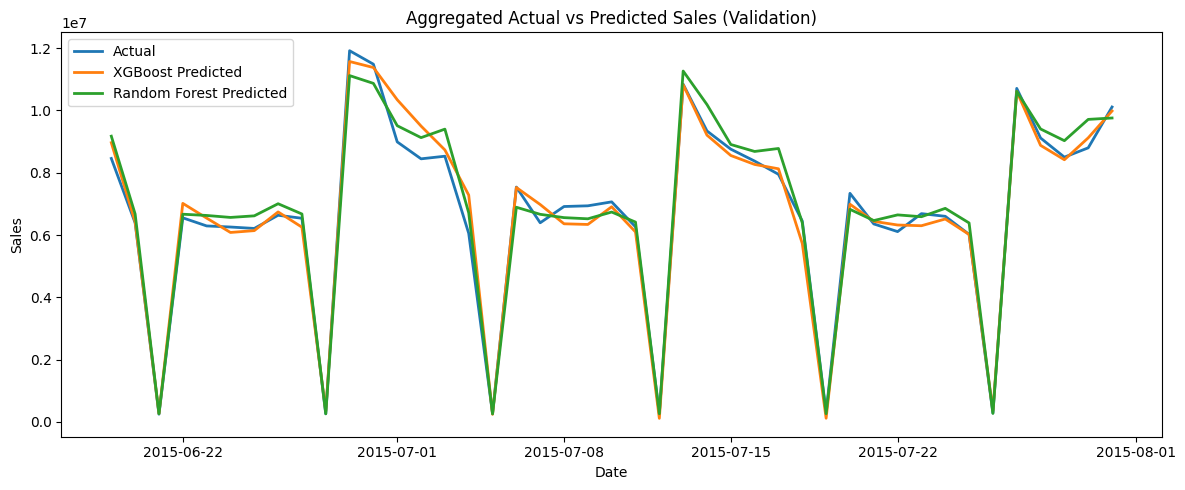

In [22]:
val_plot = val_data[['Date', 'Sales']].copy()
val_plot['XGB_Pred'] = xgb_preds
val_plot['RF_Pred'] = rf_preds
val_plot['Date'] = pd.to_datetime(val_plot['Date'])

agg = val_plot.groupby('Date', as_index=False).sum()

plt.figure(figsize=(12,5))
plt.plot(agg['Date'], agg['Sales'], label='Actual', linewidth=2)
plt.plot(agg['Date'], agg['XGB_Pred'], label='XGBoost Predicted', linewidth=2)
plt.plot(agg['Date'], agg['RF_Pred'], label='Random Forest Predicted', linewidth=2)
plt.title("Aggregated Actual vs Predicted Sales (Validation)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

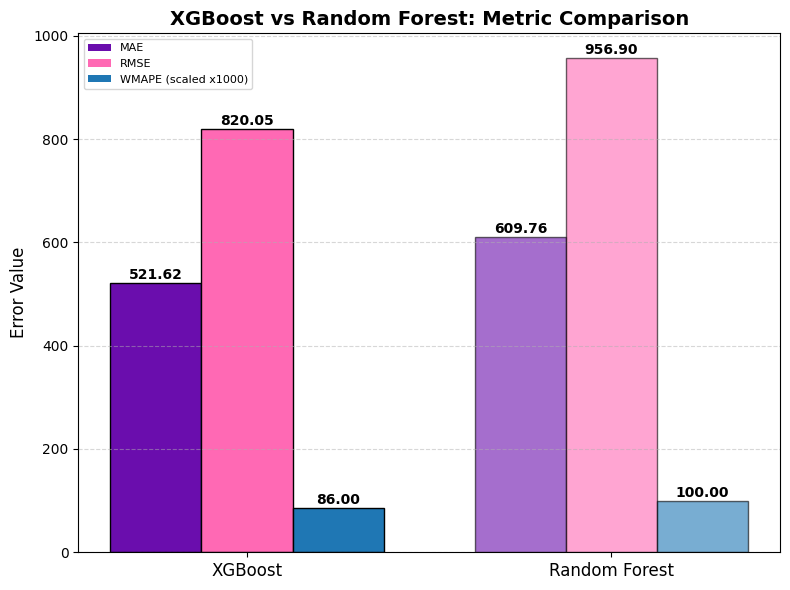

In [27]:
xgb_scores = [521.62, 820.05, 0.086*1000] 
rf_scores = [609.76, 956.90, 0.100*1000]
metrics = ['MAE', 'RMSE', 'WMAPE (scaled x100)']
colors = ['#6a0dad', '#ff69b4', '#1f77b4']

models = ['XGBoost', 'Random Forest']
x = np.arange(len(models))
bar_width = 0.25

plt.figure(figsize=(8,6))

plt.bar(x[0] - bar_width, xgb_scores[0], width=bar_width, color=colors[0], edgecolor='k')
plt.bar(x[0], xgb_scores[1], width=bar_width, color=colors[1], edgecolor='k')
plt.bar(x[0] + bar_width, xgb_scores[2], width=bar_width, color=colors[2], edgecolor='k')

plt.bar(x[1] - bar_width, rf_scores[0], width=bar_width, color=colors[0], alpha=0.6, edgecolor='k')
plt.bar(x[1], rf_scores[1], width=bar_width, color=colors[1], alpha=0.6, edgecolor='k')
plt.bar(x[1] + bar_width, rf_scores[2], width=bar_width, color=colors[2], alpha=0.6, edgecolor='k')

plt.xticks(x, models, fontsize=12)
plt.ylabel('Error Value', fontsize=12)
plt.title('XGBoost vs Random Forest: Metric Comparison', fontsize=14, fontweight='bold')

legend_elements = [
    Patch(facecolor='#6a0dad', label='MAE'),
    Patch(facecolor='#ff69b4', label='RMSE'),
    Patch(facecolor='#1f77b4', label='WMAPE (scaled x1000)'),
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=8)

# For XGBoost
plt.text(x[0] - bar_width, xgb_scores[0] + 2, f"{xgb_scores[0]:.2f}", ha='center', va='bottom', fontweight='bold')
plt.text(x[0], xgb_scores[1] + 2, f"{xgb_scores[1]:.2f}", ha='center', va='bottom', fontweight='bold')
plt.text(x[0] + bar_width, xgb_scores[2] + 2, f"{xgb_scores[2]:.2f}", ha='center', va='bottom', fontweight='bold')

# For Random Forest
plt.text(x[1] - bar_width, rf_scores[0] + 2, f"{rf_scores[0]:.2f}", ha='center', va='bottom', fontweight='bold')
plt.text(x[1], rf_scores[1] + 2, f"{rf_scores[1]:.2f}", ha='center', va='bottom', fontweight='bold')
plt.text(x[1] + bar_width, rf_scores[2] + 2, f"{rf_scores[2]:.2f}", ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Feature Importance (built-in)

C:\Users\User\AppData\Local\Temp\ipykernel_26904\3603699149.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=imp_df.head(20), palette='viridis')


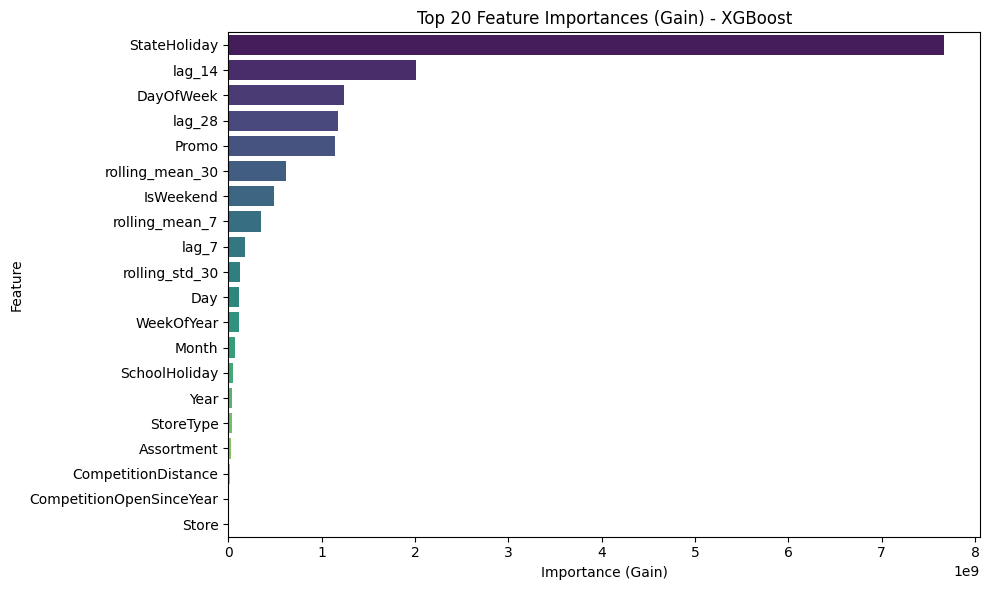

In [28]:
# Get importance scores (gain)
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Map f0, f1, ... to real feature names
imp_df = pd.DataFrame({
    'feature': [FEATURES[int(k[1:])] for k in importance_dict.keys()],
    'importance': list(importance_dict.values())
}).sort_values('importance', ascending=False)


# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=imp_df.head(20), palette='viridis')
plt.title("Top 20 Feature Importances (Gain) - XGBoost")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# SHAP (explainable AI)

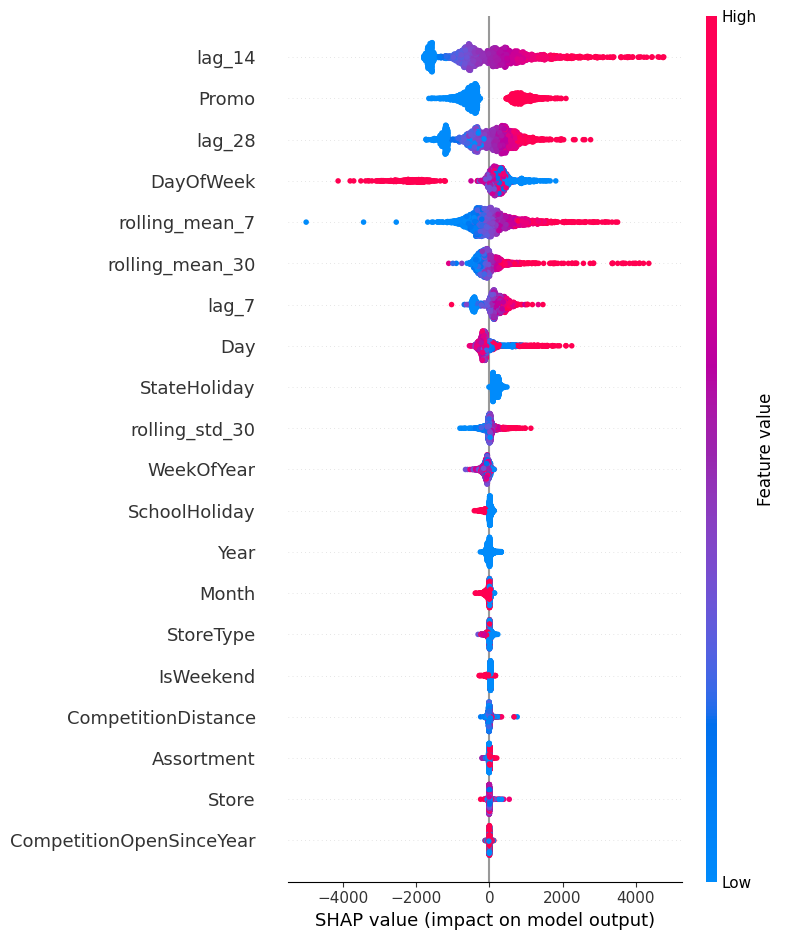

In [29]:
# Sample 2000 rows for speed
sample_X = X_val[np.random.choice(len(X_val), min(2000, len(X_val)), replace=False)]

explainer = shap.Explainer(xgb_model)
shap_values = explainer(sample_X)

shap.summary_plot(shap_values, feature_names=FEATURES, max_display=20)